In [1]:
import requests
import zipfile
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
#データの読み込み
data = pd.DataFrame(data=[4,3,4,5,5,2,3,1,4,0,1,5,5,6,5,4,4,5,3,4], columns=['y'])
data['N'] = np.ones(20, dtype=np.int) * 8

data

,y,N
0,4,8
1,3,8
2,4,8
3,5,8
4,5,8
5,2,8
6,3,8
7,1,8
8,4,8
9,0,8


In [3]:
data.describe()
#本データは過分散にはなっていない

,y,N
count,20.000000,20.0
mean,3.650000,8.0
std,1.598519,0.0
min,0.000000,8.0
25%,3.000000,8.0
50%,4.000000,8.0
75%,5.000000,8.0
max,6.000000,8.0


(array([1., 2., 1., 3., 6., 6., 1.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5]),
 <a list of 7 Patch objects>)

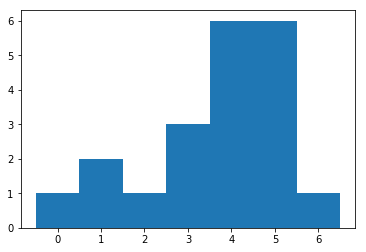

In [4]:
#ヒストグラム表示
plt.hist(data['y'], bins=np.arange(-0.5, 7.5, 1))

In [5]:
#2項分布に従うと仮定して一定モデルで推定する
model = smf.glm('y + I(N-y)~ 1', data=data, family=sm.families.Binomial())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                   20
Model:                            GLM   Df Residuals:                       19
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -37.748
Date:                Sat, 29 Feb 2020   Deviance:                       28.722
Time:                        17:29:29   Pearson chi2:                     24.5
No. Iterations:                     3   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1754      0.159     -1.105      0.269      -0.487       0.136
==============================================================================
"""

In [6]:
#最尤推定値の数値計算結果
#Interceptはモデルのパラメータの推定値
#最尤推定した2項分布の成功率ではないことに注意

#logit y = C
#y = logistic(C) = (1 / (1 + np.exp(0.1754)))
(1 / (1 + np.exp(0.1754)))

#np = 0.45 * 8 ~ 3.6なのでdata.describeと一致する
#解析的に求める場合は微分して0となる値を求める

0.45626207623047454

### ふらふら試行錯誤

In [7]:
#このアプローチは点推定であって分布を推定していないことに注意
def loglikelihood(data, q):
    ll = 0
    
    for i, r in data.iterrows():
        ll = ll + math.log(scipy.special.comb(r['N'], r['y'])) + r['y']*math.log(q) + (r['N'] - r['y'])*math.log(1 - q)
        
    return ll

def maximum_likelihood_estimation(data, q_start, number_of_trials):
    q_current = q_start
    ll_current = loglikelihood(data, q_current)
    
    q = [q_current]
    ll = [ll_current]
    
    for r in np.random.random(number_of_trials):
        q_new = q_current + 0.01 if r > 0.5 else q_current - 0.01
        ll_new = loglikelihood(data, q_new)
        
        if ll_current < ll_new:
            q_current = q_new
            ll_current = ll_new
            
        q.append(q_current)
        ll.append(ll_current)
    
    return q, ll

q_03, ll_03 = maximum_likelihood_estimation(data, 0.3, 100)
q_06, ll_06 = maximum_likelihood_estimation(data, 0.6, 100)

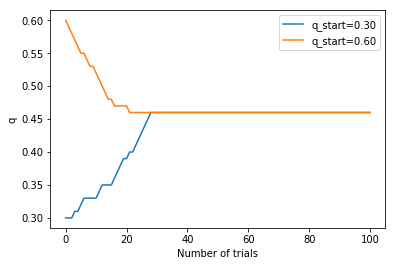

In [8]:
# 推定する過程をプロット
plt.plot(np.arange(len(q_03)), q_03, label='q_start=0.30')
plt.plot(np.arange(len(q_06)), q_06, label='q_start=0.60')
plt.legend()
plt.xlabel('Number of trials')
plt.ylabel('q')
plt.show()

### メトロポリス法

In [9]:
#あくまでもほしいのは特定の値ではなく値全体のなす分布
#アルゴリズム実行後の最終値を求めるのが目的ではない
log_llh = lambda q, data : sum([math.log(scipy.special.comb(8, y)) + y * np.log(q) + (8 - y) * np.log(1 - q) for y in list(data.y)])

def metropolis(q_init, loop_count):
    
    q_list = []
    current_q = q_init
    current_log_llh = log_llh(current_q, data)
    count = 0
    
    while(count < loop_count):
        seed1 = np.random.random()
        seed2 = np.random.random()     

        if seed1 > 0.5:
            step = 0.01
        else:
            step = -0.01
        
        new_q = current_q + step

        if new_q <= 0.01:
            new_q = 0.02
        if new_q >= 0.99:
            new_q = 0.98

        new_log_llh = log_llh(new_q, data)

        if(new_log_llh > current_log_llh) or (np.exp(new_log_llh - current_log_llh) > seed2):
                current_q = new_q
                current_log_llh = log_llh(current_q, data)
    
        q_list.append(current_q)
        count += 1
      
    return q_list

In [37]:
#サンプル数100
q_list_100 = metropolis(0.3, 100)
count_100, value_100 = np.histogram(q_list, bins=1000, range=(0.00, 1.00))

In [38]:
#サンプル数1000
q_list_1000 = metropolis(0.3, 1000)
count_1000, value_1000 = np.histogram(q_list, bins=1000, range=(0.00, 1.00))

In [24]:
#サンプル数10000
q_list_10000 = metropolis(0.3, 10000)
count_10000, value_10000 = np.histogram(q_list, bins=1000, range=(0.00, 1.00))

In [25]:
#サンプル数200000
q_list_20000 = metropolis(0.3, 20000)
count_20000, value_20000 = np.histogram(q_list, bins=1000, range=(0.00, 1.00))

### qの値の遷移

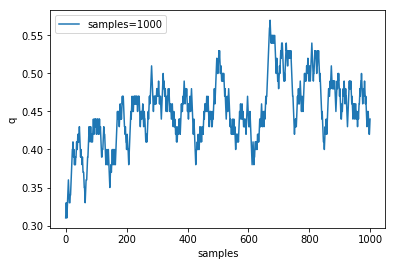

In [29]:
# サンプル数1000
plt.plot(np.arange(len(q_list_1000)), q_list_1000, label='samples=1000')

plt.legend()
plt.xlabel('samples')
plt.ylabel('q')
plt.show()

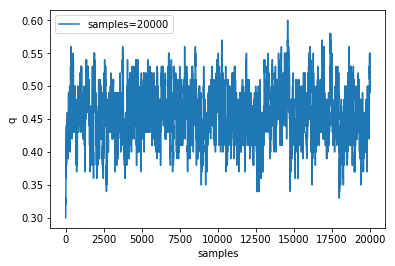

In [27]:
# サンプル数20000
plt.plot(np.arange(len(q_list_20000)), q_list_20000, label='samples=20000')

plt.legend()
plt.xlabel('samples')
plt.ylabel('q')
plt.show()

### qのヒストグラム
* qの値の遷移図のy軸を横に倒したことに相当
* 試行回数が増えるほどqの最尤推定値がピークの分布に収束しているのがわかる

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  8.,  8.,  5.,  2.,  2.,  3.,  1.,  1.,  2.,  4.,
        12.,  8.,  3.,  1.,  1.,  1.,  1.,  1.,  3.,  3.,  4.,  7.,  4.,
         2.,  5.,  5.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0

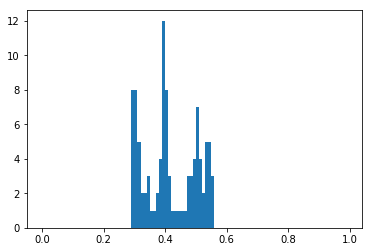

In [39]:
plt.hist(q_list_100, bins=np.arange(0.0, 1.0, 0.01))

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  2.,  2.,  4.,  6.,  2.,  4., 10., 21.,
        43., 51., 49., 58., 75., 82., 71., 65., 63., 67., 76., 62., 68.,
        53., 21., 12., 11., 13.,  7.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0

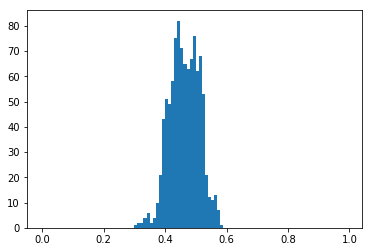

In [40]:
plt.hist(q_list_1000, bins=np.arange(0.0, 1.0, 0.01))

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 4.000e+00, 0.000e+00, 9.000e+00,
        6.000e+00, 9.000e+00, 7.000e+00, 1.300e+01, 2.100e+01, 1.700e+01,
        4.300e+01, 1.110e+02, 1.940e+02, 2.630e+02, 3.330e+02, 4.940e+02,
        6.620e+02, 8.020e+02, 9.020e+02, 1.047e+03, 1.099e+03, 9.920e+02,
        8.380e+02, 6.810e+02, 5.330e+02, 3.800e+02, 1.970e+02, 1.380e+02,
        9.900e+01, 6.400e+01, 2.800e+01, 7.000e+00, 3.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

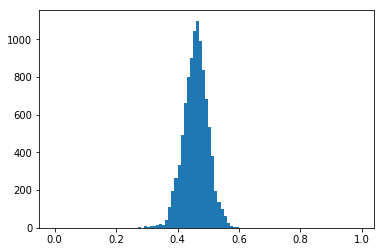

In [36]:
plt.hist(q_list_10000, bins=np.arange(0.0, 1.0, 0.01))

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 4.000e+00, 4.000e+00, 1.300e+01, 3.900e+01, 1.000e+00,
        6.800e+01, 1.600e+02, 2.850e+02, 4.510e+02, 6.620e+02, 9.450e+02,
        1.361e+03, 1.694e+03, 1.899e+03, 1.950e+03, 1.979e+03, 1.982e+03,
        1.762e+03, 1.446e+03, 1.120e+03, 8.210e+02, 5.590e+02, 3.470e+02,
        2.210e+02, 1.310e+02, 6.200e+01, 1.900e+01, 7.000e+00, 2.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

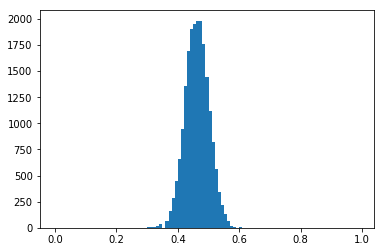

In [35]:
plt.hist(q_list_20000, bins=np.arange(0.0, 1.0, 0.01))